In [1]:
# 변수의 shape, type, value 확인
def p(var,_name="") :
    if _name != "" : print(f'<<{_name}>>')
    if type(var)!=type([]):
        try:      print(f'Shape:{var.shape}')
        except :  pass
    print(f'Type: {type(var)}')
    print(f'Values: {var}')

def pst(_x,_name=""):
    print(f'<<{_name}>> Shape{_x.shape}, {type(_x)}')
def ps(_x,_name=""):
    print(f'<<{_name}>> Shape{_x.shape}')

# 실습: Self-Attention

ref: https://github.com/philipperemy/keras-attention-mechanism

In [2]:
import tensorflow as tf
import keras
import keras.layers as layers
from keras import Input
from keras.layers import LSTM, Layer
from keras.layers import Dense, Lambda, Dot, Activation, Concatenate, Flatten
from keras.models import Model
from keras.utils import plot_model
from keras import Sequential
from keras.callbacks import Callback

from IPython import display
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 3.5]
plt.rcParams["font.size"] = "10"

tf.__version__,keras.__version__

('2.18.0', '3.8.0')

## Attention Layer

```python
def ScaledDotProductAttention(Q, K, V):
    sqrt_d_k = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
    q_k = tf.matmul(Q, K, transpose_b=True)
    scores =  q_k / sqrt_d_k
    weights = layers.Activation('softmax')(scores)
    return tf.matmul(weights, V)
```    

**내부 연결과 동작을 확인하기 위해 Lambda layer로 coding**

In [3]:
from keras.layers import Lambda

def myAttention(Q, K, V, l=""):
    q_k        = Lambda(lambda x: tf.matmul(x[0],x[1],transpose_b=True),name="q_k"+l)((Q, K))
    d_k        = Lambda(lambda x: tf.cast(tf.shape(x)[-1],tf.float32),name="d_k"+l)(K)
    sacaled_qk = Lambda(lambda x: tf.divide(x[0],tf.sqrt(tf.cast(tf.shape(x[1])[-1],tf.float32))),name="sacaled_qk"+l)((q_k, K))
    weight     = Activation('softmax',name="attention_weight"+l)(sacaled_qk)
    output     = Lambda(lambda x: tf.matmul(x[0],x[1]), name='output'+l)((weight,V))
    return output

In [4]:
hidden_dim=10 # input Dense_hidden_units
n_classes=10  # out_dim
shape=(20,5)  # (seq., features)

inputs = Input(shape=shape)
Q = Dense(hidden_dim, name='Q')(inputs)#(bs, seq, hidden_dim)
K = Dense(hidden_dim, name='K')(inputs)#(bs, seq, hidden_dim)
V = Dense(n_classes, name='V')(inputs) #(bs, seq, out_dim)
output = myAttention(Q, K, V)#(bs, seq, out_dim)
model = Model(inputs,output)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 20, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Q (Dense)           │ (None, 20, 10)    │         60 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ K (Dense)           │ (None, 20, 10)    │         60 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ q_k (Lambda)        │ (None, 20, 20)    │          0 │ Q[0][0], K[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sacaled_qk (Lambda) │ (None, 20, 20)    │          0 │ q_k[0][0],        │
│                     │                   │            │ K[0][0]           │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_weight    │ (None, 20, 20)    │          0 │ sacaled_qk[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V (Dense)           │ (None, 20, 10)    │         60 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Lambda)     │ (None, 20, 10)    │          0 │ attention_weight… │
│                     │                   │            │ V[0][0]           │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 180 (720.00 B)

 Trainable params: 180 (720.00 B)

 Non-trainable params: 0 (0.00 B)

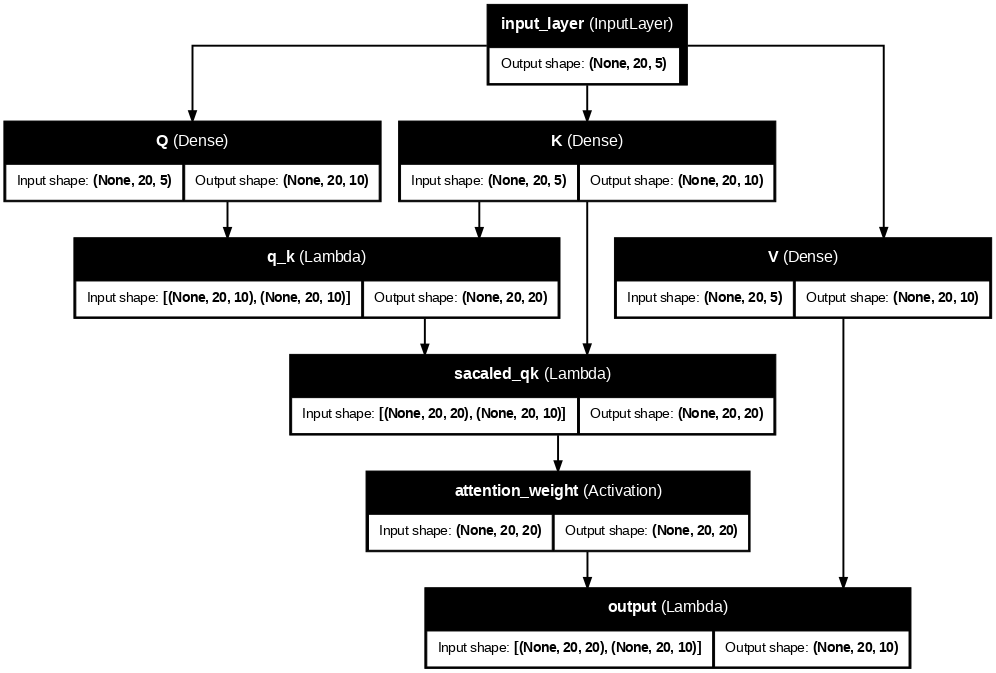

In [5]:
model.summary()
plot_model(model, show_shapes=True,show_layer_names=True, dpi=70)

## Find max number

### Data generation

In [6]:
np.random.seed(7)

seq_length = 10
num_samples = 5000
x_dim = 1
## x_data.shape:(bs,seq,x_dim)
x_data_base = np.random.uniform(size=(num_samples, seq_length, x_dim))
# max값이 5~10 사이에서 변하도록, 큰값이 고정되면 대충 큰값을 출력하도록 학습됨
random_multipliers = np.random.uniform(low=5.0, high=10.0, size=(num_samples, 1, 1))
x_data = x_data_base * random_multipliers
y_data = np.max(x_data, axis=1) #(bs,x_dim):(bs,1)

| 항목            | 내용                                        |
| ------------- | ----------------------------------------- |
| 입력 (`x_data`) | 10길이 시계열 (1D), 값은 0\~10 사이                |
| 출력 (`y_data`) | 해당 시퀀스의 최대값                               |
| 목표            | 시퀀스에서 최대값을 추론하는 모델을 학습                    |
| 실험 의도         | Attention이 유용한지를 시각적으로 확인하기 위한 실험         |
| 가능한 모델        | RNN, GRU, LSTM, Self-Attention 등 비교 실험 가능 |


In [7]:
ps(x_data,"x_data")
ps(y_data,"y_data")

<<x_data>> Shape(5000, 10, 1)
<<y_data>> Shape(5000, 1)


In [8]:
p(x_data[0:2,:,0])
p(y_data[0:2,0])

Shape:(2, 10)
Type: <class 'numpy.ndarray'>
Values: [[0.43941465 4.49109453 2.52454143 4.1660113  5.63166754 3.10088163
  2.8856586  0.41490018 1.54578252 2.8785299 ]
 [5.75638401 6.81158159 3.22842551 0.55880178 2.44199569 7.70868435
  1.80841253 3.83169053 7.89184735 0.21101765]]
Shape:(2,)
Type: <class 'numpy.ndarray'>
Values: [5.63166754 7.89184735]


### Attention model

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Q (Dense)           │ (None, 10, 5)     │         10 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ K (Dense)           │ (None, 10, 5)     │         10 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ q_k (Lambda)        │ (None, 10, 10)    │          0 │ Q[0][0], K[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sacaled_qk (Lambda) │ (None, 10, 10)    │          0 │ q_k[0][0],        │
│                     │                   │            │ K[0][0]           │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_weight    │ (None, 10, 10)    │          0 │ sacaled_qk[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V (Dense)           │ (None, 10, 1)     │          2 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Lambda)     │ (None, 10, 1)     │          0 │ attention_weight… │
│                     │                   │            │ V[0][0]           │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 10)        │          0 │ output[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │         11 │ flatten[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33 (132.00 B)

 Trainable params: 33 (132.00 B)

 Non-trainable params: 0 (0.00 B)

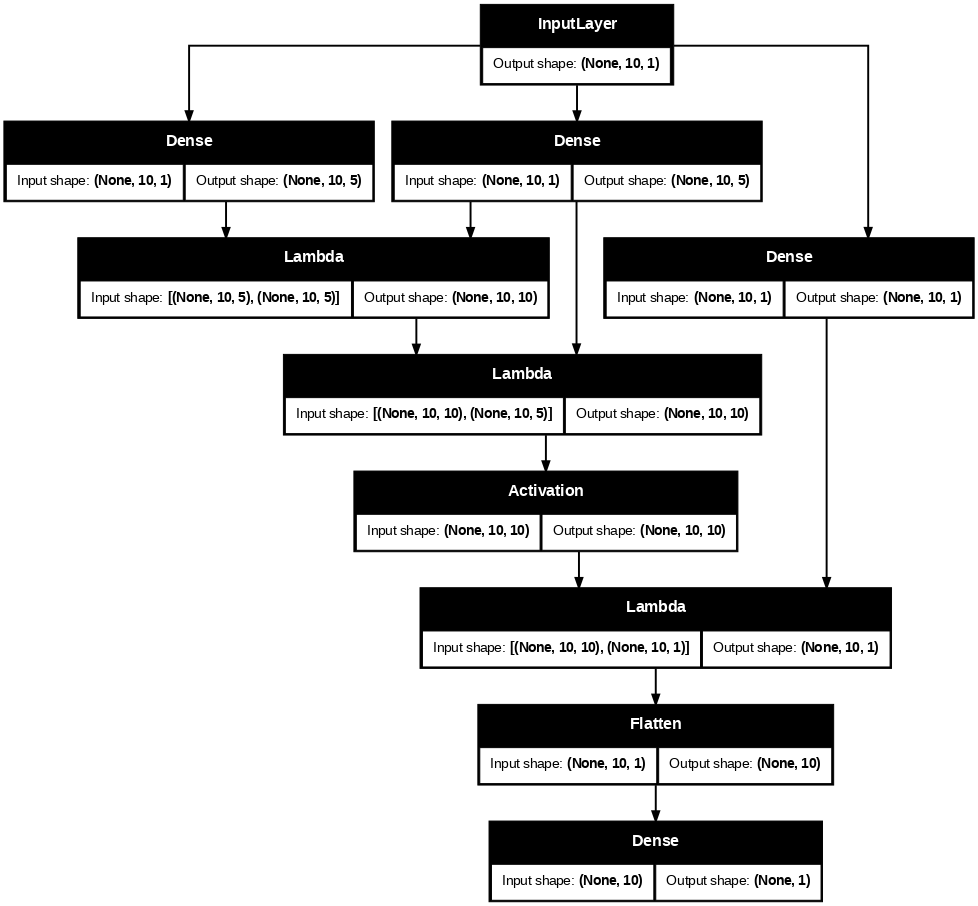

In [9]:
hidden_dim=5
n_classes=1
shape=(10,1) #(seq, x_dim)

def Att_model():
    inputs = Input(shape=shape)
    Q = Dense(hidden_dim, name='Q')(inputs) #(bs, 10, 5)
    K = Dense(hidden_dim, name='K')(inputs) #(bs, 10, 5)
    V = Dense(n_classes, name='V')(inputs)  #(bs, 10, 1)
    x = myAttention(Q, K, V)             #(bs, 10, 1)
    x = Flatten()(x)                        #(bs, 10)
    output = Dense(n_classes)(x)            #(bs,1)
    return Model(inputs,output)

model=Att_model()
model.summary()
plot_model(model, show_shapes=True,dpi=70)

In [10]:
def create_argmax_mask(x):
    idx = np.argmax(x, axis=1)
    mask = np.zeros_like(x)
    mask[np.arange(x.shape[0]), idx] = 1
    return mask

### Training 중에 feature map 시각화 하기
class VisualizeAttentionMap(Callback):
    def __init__(self, model, x):
        super().__init__()
        self.x = x
        # attention weight를 출력하는 모델 구성
        attn_layer = model.get_layer("attention_weight")
        self.attn_model = Model(inputs=model.input, outputs=attn_layer.output)

    def on_epoch_begin(self, epoch, logs=None):
        attn = self.attn_model(self.x, training=False).numpy()  # (bs, seq, seq)
        attention_map = np.sum(attn, axis=1)  # (bs, seq)

        x = self.x[..., 0]
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 2.5))
        maps = [attention_map, create_argmax_mask(attention_map), create_argmax_mask(x)]
        maps_names = ['Attention', 'Argmax(Attn)', 'Argmax(Input)']

        for i, ax in enumerate(axes.flat):
            im = ax.imshow(maps[i], interpolation='none', cmap='jet')
            ax.set_ylabel(maps_names[i] + '\nsamples')
            ax.set_xlabel('time steps')
            ax.xaxis.set_ticks([])
            ax.yaxis.set_ticks([])

        display.clear_output(wait=True)
        plt.suptitle(f'Epoch {epoch} - Attention Visualization')
        plt.show()


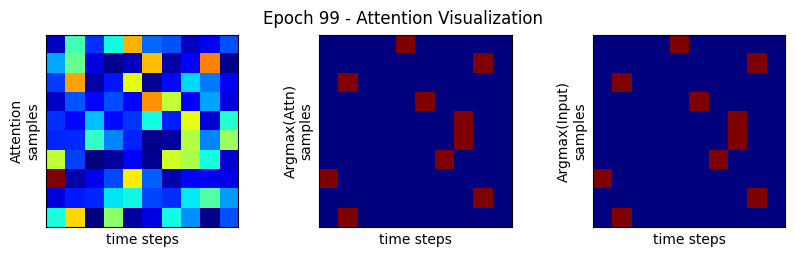

CPU times: user 30 s, sys: 1.92 s, total: 31.9 s
Wall time: 28.1 s


In [11]:
%%time
batch_size = 256
max_epoch = 100

model = Att_model()
model.compile(loss='mse', optimizer='adam', metrics=['mape','mae'])

visualize = VisualizeAttentionMap(model, x_data[0:10])
history = model.fit(
    x_data, y_data,
    epochs=100,
    batch_size=256,
    validation_split=0.2,
    callbacks=[visualize],
    verbose=0
)

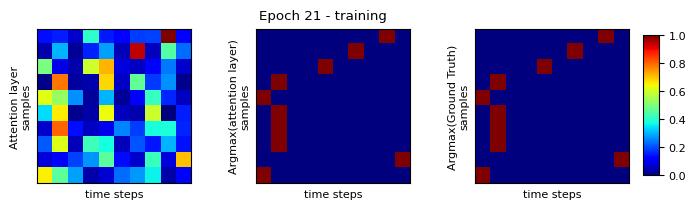

In [12]:
y_pred = model.predict(x_data[0:5,:,:],verbose=0)
p(np.max(x_data[0:5,:,0],axis=1),'True')
p(y_pred[0:5,0],'Pred')

<<True>>
Shape:(5,)
Type: <class 'numpy.ndarray'>
Values: [5.63166754 7.89184735 8.12301982 6.73292802 5.54346673]
<<Pred>>
Shape:(5,)
Type: <class 'numpy.ndarray'>
Values: [5.0092773 8.205053  8.210735  6.288555  5.052311 ]


In [13]:
def plot_loss(history,semilog=True):
    plt.figure(figsize=(4,3))
    keys = history.history.keys()
    keys = list(keys)
    min_mape = np.min(history.history['val_mape'])
    min_mae = np.min(history.history['val_mae'])
    plt.title(f'Min mape:{min_mape:.2f}, mae:{min_mae:.3f}')
    plt.plot(history.history['val_mape'], linestyle='--', label='val_mape')
    plt.plot(history.history['val_mae'], linestyle='-', label='val_mae')
    #plt.ylim(0.6, 0.9)
    if semilog : plt.semilogy()
    plt.legend()
    plt.grid()
    plt.show()
    print(f"Min Mape:{min_mape:.2f}, Min Mae:{min_mae:.3f}")

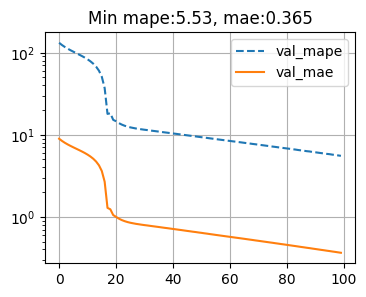

Min Mape:5.53, Min Mae:0.365


In [14]:
plot_loss(history)

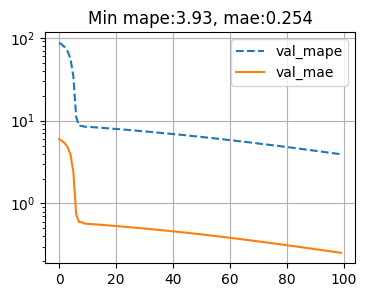

###  Dense model

In [15]:
shape=(10,1)

inputs = Input(shape=shape)
x = Dense(7)(inputs) #(bs,10,7)
x = Dense(1)(x)      #(bs,10,1)
x = Flatten()(x)     #(bs,10)
output = Dense(1)(x) #(bs,1)
model = Model(inputs,output)

model.summary()
#plot_model(model,'model.png',show_shapes=True)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 10, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10, 7)          │            14 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10, 1)          │             8 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33 (132.00 B)

 Trainable params: 33 (132.00 B)

 Non-trainable params: 0 (0.00 B)

In [16]:
%%time
model.compile(loss='mse', optimizer='adam', metrics=['mape','mae'])

batch_size = 256
max_epoch = 100
history = model.fit(x_data, y_data, epochs=max_epoch, batch_size=batch_size, validation_split=0.2, verbose=1 )

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 59.4539 - mae: 6.5555 - mape: 96.0894 - val_loss: 55.0735 - val_mae: 6.2886 - val_mape: 91.4252
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 50.4147 - mae: 6.0272 - mape: 88.1226 - val_loss: 45.9384 - val_mae: 5.7458 - val_mape: 83.4910
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 42.3407 - mae: 5.5395 - mape: 80.7935 - val_loss: 39.0930 - val_mae: 5.2893 - val_mape: 76.7979
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 35.3140 - mae: 5.0520 - mape: 74.1070 - val_loss: 33.7109 - val_mae: 4.8694 - val_mape: 70.6263
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 29.9715 - mae: 4.5949 - mape: 67.5586 - val_loss: 29.0671 - val_mae: 4.4538 - val_mape: 64.5258
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 25.6597 - mae: 4.1768 - mape: 61.2269 - val_loss: 24.9343 - val_mae: 4.0469 - val_mape: 58.5819
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 22.3684 - 

Wall time: 10.2 s

In [17]:
y_pred = model.predict(x_data[0:10,:,:],verbose=0)
p(np.max(x_data[0:10,:,0],axis=1),'true')
p(y_pred[0:10,0],'pred')

<<true>>
Shape:(10,)
Type: <class 'numpy.ndarray'>
Values: [5.63166754 7.89184735 8.12301982 6.73292802 5.54346673 6.62683847
 8.52340089 7.87651282 4.43681479 8.62373111]
<<pred>>
Shape:(10,)
Type: <class 'numpy.ndarray'>
Values: [6.149743  7.1530385 7.776266  6.257801  6.2922955 7.517896  7.9518766
 7.818097  6.731139  6.6352267]


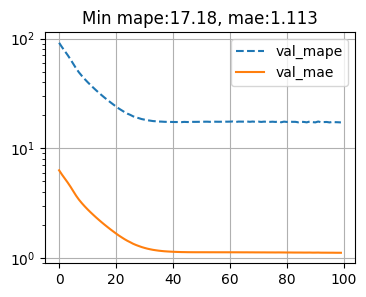

Min Mape:17.18, Min Mae:1.113


In [18]:
plot_loss(history)

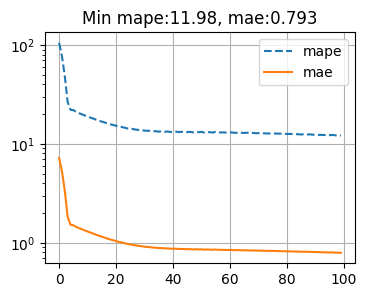

**Dense model**  
Min val_mape: 7.34480094909668  
Min val_mse: 0.6668574810028076  
**Attention model**  
Min val_mape: 5.6466064453125  
Min val_mse: 0.4134947657585144  


## Add two number

In [19]:
from keras.layers import Dropout, LSTM, LayerNormalization

### Data generation

In [20]:
def task_add_two_numbers_after_delimiter(n, seq_length, delimiter = 0.0,
                                         index_1=None, index_2=None, test=False):
    #Task: Add the two numbers that come right after the delimiter.
    #x = [1, 2, 3, 0, 4, 5, 6, 0, 7, 8]. Result is y = 4 + 7 = 11.
    x = np.random.uniform(0, 1, (n, seq_length))*10.0
    y = np.zeros(shape=(n, 1))
    for i in range(len(x)):
        if index_1 is None and index_2 is None:
            a, b = np.random.choice(range(1, len(x[i])), size=2, replace=False)
        else:
            a, b = index_1, index_2
        x[i, a - 1:a] = delimiter
        x[i, b - 1:b] = delimiter
        y[i] = x[i, a:a + 1] + x[i, b:b + 1]
        if test :
            print(a,b)
            print(x[i],y[i])
    x = np.expand_dims(x, axis=-1)
    return x, y

In [21]:
np.random.seed(7)

n_train = 2
n_test  = 1
seq = 20
x_train, y_train = task_add_two_numbers_after_delimiter(n_train, seq, test=True)
print("")
test_index_1 = 4
test_index_2 = 9
x_test, y_test = task_add_two_numbers_after_delimiter(
                          n_test, seq, 0, test_index_1, test_index_2, test=True)

1 3
[0.         7.79918792 0.         7.23465178 9.77989512 5.3849587
 5.01120464 0.72051133 2.6843898  4.99882501 6.79229996 8.03739036
 3.80941133 0.65936347 2.88145599 9.09593528 2.13385354 4.52123962
 9.3120602  0.24899228] [15.0338397]
19 2
[6.00548917 0.         2.30302879 5.48489919 9.09128375 1.33169446
 5.23412581 7.50409859 6.69013241 4.6775286  2.0484909  4.90765889
 3.72384689 4.77401155 3.65890386 8.37917994 7.68647507 3.13994677
 0.         2.76049048] [5.06351927]

4 9
[2.35120407 9.64971    9.45048224 0.         4.72323996 8.41476715
 1.31110642 3.08733657 0.         7.41847201 4.85825229 1.36876119
 3.4353653  3.2442617  3.00418904 1.655014   4.14901773 4.48120658
 7.74900376 7.96390701] [12.14171197]


### Positional encoding  

$$\Large{PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})} $$

In [22]:
def positional_encoding(length, depth):          #(seq, x_dim)
  depth = depth/2
  positions = np.arange(length)[:, np.newaxis]   #(seq, 1): 0 ~ seq_len
  depths = np.arange(depth)[np.newaxis, :]/depth #(1, x_dim/2): 0 ~ 1

  angle_rates = 1 / (10000**depths)              #(1, x_dim/2): 1 ~ 1/(10000)
  angle_rads = positions * angle_rates           #(seq, x_dim/2)

  pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)
  return tf.cast(pos_encoding, dtype=tf.float32) #(seq_len, x_dim)

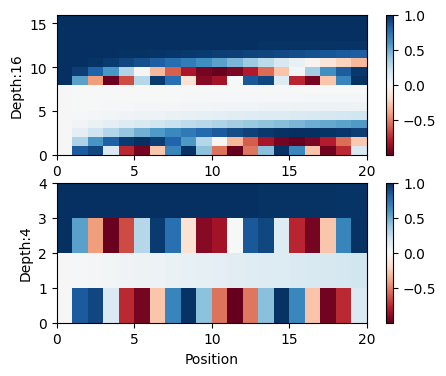

In [23]:
length = x_train.shape[1] # 20

pos_encoding_16 = positional_encoding(length=length, depth=16)
pos_encoding_4 = positional_encoding(length=length, depth=4)

# Plot the dimensions.
plt.figure(figsize=(5,4))
plt.subplot(2,1,1)
plt.pcolormesh(pos_encoding_16.numpy().T, cmap='RdBu')
plt.colorbar()
plt.ylabel('Depth:16')
plt.subplot(2,1,2)
plt.pcolormesh(pos_encoding_4.numpy().T, cmap='RdBu')
plt.colorbar()
plt.ylabel('Depth:4')
plt.xlabel('Position')
plt.show()

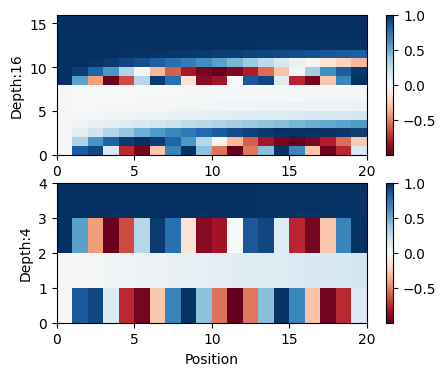

In [24]:
## Append position code
def pos_concat(x) :
    idx = positional_encoding(length=x.shape[1], depth=4)
    idx = np.tile(idx+1,(x.shape[0],1,1)) # +1:양수값으로
    ps(x,'x'),ps(idx,'idx')
    ret = keras.layers.concatenate([x,idx],axis=-1)
    ps(ret,'[x,idx]')
    return ret

In [25]:
np.random.seed(6)

n_train = 20000
n_val = 400
n_test = 10
# data. definition of the problem.
seq_length = 20
#(bs,20,1)
x_train, y_train = task_add_two_numbers_after_delimiter(n_train, seq_length)
x_val, y_val = task_add_two_numbers_after_delimiter(n_val, seq_length)

# 시각화를 위해 '0'위치를 고정
index_1 = 4
index_2 = 9
x_test, y_test = task_add_two_numbers_after_delimiter(n_test, seq_length, 0, index_1, index_2)
# test_index 위치를 시각화 하기 위한 준비
x_test_mask = np.zeros_like(x_test[..., 0]) #(10,20,1)
x_test_mask[:, index_1:index_1 + 1] = 5
x_test_mask[:, index_2:index_2 + 1] = 5

# concat(x_data, position_code)
x_train = pos_concat(x_train) #(20000,20,5)
x_val = pos_concat(x_val)     #(400,20,5)
x_test = pos_concat(x_test)   #(10,20,5)

<<x>> Shape(20000, 20, 1)
<<idx>> Shape(20000, 20, 4)
<<[x,idx]>> Shape(20000, 20, 5)
<<x>> Shape(400, 20, 1)
<<idx>> Shape(400, 20, 4)
<<[x,idx]>> Shape(400, 20, 5)
<<x>> Shape(10, 20, 1)
<<idx>> Shape(10, 20, 4)
<<[x,idx]>> Shape(10, 20, 5)


In [26]:
p(x_val[:2,:,0],'x_val')
print("===")
p(y_val[:2,0],'y_val')

<<x_val>>
Shape:(2, 20)
Type: <class 'tensorflow.python.framework.ops.EagerTensor'>
Values: [[2.534355  3.1068783 9.713581  5.9003654 1.3962394 0.        3.4249299
  2.2833002 2.1486905 0.        6.4391866 5.6013274 7.7686515 2.0698917
  0.8486596 6.9395366 3.4517882 1.8376313 4.0174284 4.8913255]
 [5.5328937 4.834178  7.3424196 2.9239914 1.7097998 1.5136737 4.2154613
  6.4080076 0.        9.504097  0.        0.2313647 5.6390257 4.2529645
  7.295537  0.5774153 2.1126037 8.012429  7.2680187 8.239762 ]]
===
<<y_val>>
Shape:(2,)
Type: <class 'numpy.ndarray'>
Values: [9.86411613 9.7354613 ]


In [27]:
np.set_printoptions(suppress=True)

ps(x_train,"x_train")
ps(y_train,"y_train")
p(x_train[0,:,:],'x') #(20,5), 5:concat([v,pos])
p(y_train[0],'y')
# ps(x_test,"x_test"),ps(y_test,"y_test")
# p(x_test[0:1,:,:])
# p(y_test[0:1])

<<x_train>> Shape(20000, 20, 5)
<<y_train>> Shape(20000, 1)
<<x>>
Shape:(20, 5)
Type: <class 'tensorflow.python.framework.ops.EagerTensor'>
Values: [[8.928601   1.         1.         2.         2.        ]
 [3.319798   1.841471   1.0099999  1.5403023  1.9999499 ]
 [8.212291   1.9092975  1.0199987  0.5838531  1.9998    ]
 [0.41696626 1.14112    1.0299954  0.0100075  1.9995501 ]
 [1.0765668  0.2431975  1.0399894  0.3463564  1.9992001 ]
 [5.9505205  0.04107571 1.0499792  1.2836622  1.9987502 ]
 [5.2981734  0.7205845  1.0599641  1.9601703  1.9982005 ]
 [4.188074   1.6569866  1.0699428  1.7539022  1.997551  ]
 [3.3540785  1.9893582  1.0799147  0.85449994 1.9968017 ]
 [6.2251945  1.4121184  1.0898786  0.08886975 1.9959527 ]
 [0.         0.45597887 1.0998334  0.16092849 1.9950042 ]
 [7.358821   0.00000978 1.1097783  1.0044256  1.9939561 ]
 [5.180364   0.46342707 1.1197122  1.843854   1.9928086 ]
 [5.788586   1.420167   1.1296341  1.9074469  1.9915619 ]
 [6.453551   1.9906074  1.139543   1.136

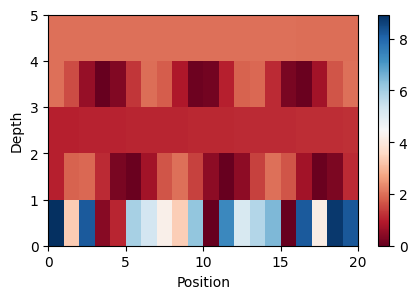

In [28]:
# Plot the dimensions.
plt.figure(figsize=(5,3))
plt.pcolormesh(x_train[0,:,:].numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

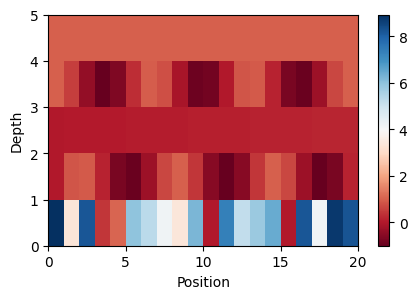

In [29]:
def plot_loss(history,semilog=True):
    plt.figure(figsize=(10,3))
    plt.subplot(1,2,1)
    min_mape = np.min(history.history['mape'])
    min_val_mape = np.min(history.history['val_mape'])
    plt.title(f'Min mape:{min_mape:.2f}, val_mape:{min_val_mape:.3f}')
    plt.plot(history.history['mape'], linestyle='--', label='mape')
    plt.plot(history.history['val_mape'], linestyle='-', label='val_mape')
    #plt.ylim(0.6, 0.9)
    if semilog : plt.semilogy()
    plt.legend()
    plt.grid()
    plt.subplot(1,2,2)
    min_mae = np.min(history.history['mae'])
    min_val_mae = np.min(history.history['val_mae'])
    plt.title(f'Min mae:{min_mae:.2f}, val_mae:{min_val_mae:.3f}')
    plt.plot(history.history['mae'], linestyle='--', label='mae')
    plt.plot(history.history['val_mae'], linestyle='-', label='val_mae')
    #plt.ylim(0.6, 0.9)
    if semilog : plt.semilogy()
    plt.legend()
    plt.grid()
    plt.show()
    print(f"Min Mape:{min_mape:.2f}, Min Mae:{min_mae:.3f}")

### Dense ( w/ index)

In [30]:
shape=x_train.shape[1:] # (20,5)
inputs = Input(shape=shape)
x = Dense(32)(inputs)  #(bs,20,32)
x = Dense(1)(x)        #(bs,20,1)
x = Flatten()(x)       #(bs,20)
output = Dense(1)(x)   #(bs,1)
model = Model(inputs,output)

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 20, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 20, 32)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 20, 1)          │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246 (984.00 B)

 Trainable params: 246 (984.00 B)

 Non-trainable params: 0 (0.00 B)

In [31]:
%%time
max_epoch = 100
batch_size = 256
model.compile(loss='mse', optimizer='adam', metrics=['mape','mae'])
history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                    epochs=max_epoch, verbose=1, batch_size=batch_size,)

Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 136.7432 - mae: 10.7498 - mape: 145.5719 - val_loss: 37.5641 - val_mae: 4.9937 - val_mape: 76.0776
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 26.3295 - mae: 4.1439 - mape: 141.3300 - val_loss: 20.4657 - val_mae: 3.7246 - val_mape: 94.6212
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19.4397 - mae: 3.5947 - mape: 154.2477 - val_loss: 19.0241 - val_mae: 3.5996 - val_mape: 95.1601
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18.2820 - mae: 3.4911 - mape: 147.4561 - val_loss: 18.6858 - val_mae: 3.5654 - val_mape: 94.1821
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17.8949 - mae: 3.4590 - mape: 137.6554 - val_loss: 18.6749 - val_mae: 3.5618 - val_mape: 96.4031
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17.6204 - mae: 3.4234 - mape: 200.1201 - val_loss: 18.6608 - val_mae: 3.5587 - val_mape: 95.9086
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18


Wall time: 31 s

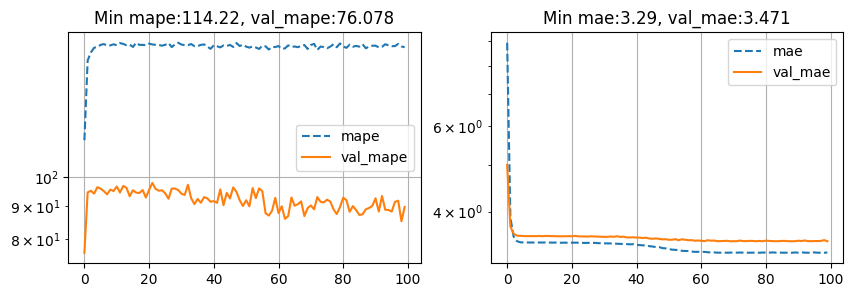

Min Mape:114.22, Min Mae:3.285


In [32]:
plot_loss(history)

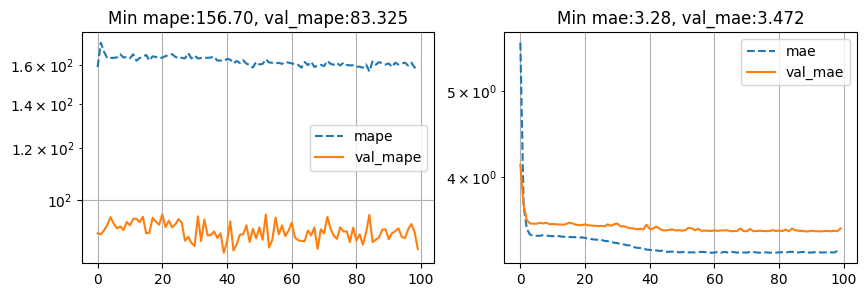

### LSTM ( wo/ index)

In [33]:
shape=(20,1)
inputs = Input(shape=shape)
x = LSTM(5,return_sequences=True)(inputs)#(bs,20,5)
x = Flatten()(x)                         #(bs,100)
output = Dense(1)(x)                     #(bs,1)
model = Model(inputs,output)

model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 20, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 20, 5)          │           140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241 (964.00 B)

 Trainable params: 241 (964.00 B)

 Non-trainable params: 0 (0.00 B)

In [34]:
%%time
max_epoch = 100
batch_size = 256

model.compile(loss='mse', optimizer='adam', metrics=['mape','mae'])
history = model.fit(x_train[:,:,0], y_train, validation_data=(x_val[:,:,0], y_val),
                    epochs=max_epoch, verbose=1, batch_size=batch_size)

Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 92.7850 - mae: 8.6418 - mape: 92.3855 - val_loss: 50.7760 - val_mae: 6.0402 - val_mape: 70.4099
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 36.3613 - mae: 4.9390 - mape: 97.4158 - val_loss: 18.6734 - val_mae: 3.5589 - val_mape: 92.6443
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 17.5994 - mae: 3.4299 - mape: 159.8785 - val_loss: 18.5919 - val_mae: 3.5486 - val_mape: 94.5679
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 17.2920 - mae: 3.3992 - mape: 131.1367 - val_loss: 18.5190 - val_mae: 3.5432 - val_mape: 93.9021
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 17.7462 - mae: 3.4402 - mape: 147.7849 - val_loss: 18.4605 - val_mae: 3.5376 - val_mape: 93.9406
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 17.5933 - mae: 3.4323 - mape: 194.8930 - val_loss: 18.4091 - val_mae: 3.5323 - val_mape: 94.1797
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 17.6287

Wall time: 37.5 s


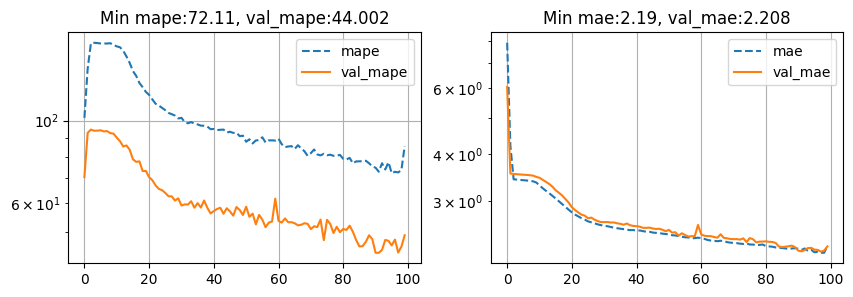

Min Mape:72.11, Min Mae:2.193


In [35]:
plot_loss(history)

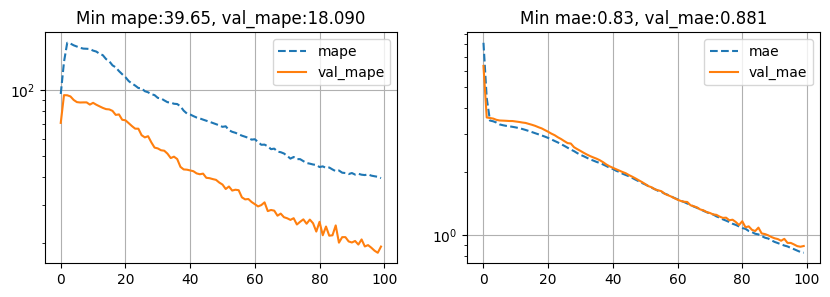

In [36]:
y_pred = model.predict(x_test[:,:,0],verbose=0)
print('True:\n',y_test)
print('Pred:\n',y_pred)

True:
 [[15.84450581]
 [ 1.97304869]
 [ 1.67674111]
 [ 5.56544162]
 [15.77302879]
 [12.65185807]
 [ 4.65781466]
 [ 6.28355721]
 [11.68882215]
 [ 0.42328507]]
Pred:
 [[17.068977 ]
 [ 5.2016044]
 [ 4.7652817]
 [ 9.519986 ]
 [10.364867 ]
 [10.89832  ]
 [ 7.769069 ]
 [ 3.5997322]
 [ 9.633578 ]
 [ 5.123644 ]]


## Self-Attention

#### FeedForward Network

In [37]:
class FeedForward(layers.Layer):
  def __init__(self, d_model, dff):
    super().__init__()
    self.ff = keras.Sequential([
      layers.Dense(dff,'gelu'),#(bs,seq,diff)
      layers.Dropout(0.1),
      layers.Dense(d_model),   #(bs,seq,d)
      # layers.Dropout(0.1),
    ])
  def call(self, x):   #(bs, seq_len, d)
    return self.ff(x)  #(bs, seq_len, d)

In [38]:
en_emb = tf.random.uniform((64, 20, 5))
sample_ffn = FeedForward(5, 32)

ps(en_emb)
ps(sample_ffn(en_emb)) #(bs,20,5)<-(bs,20,32)<-B(bs,20,5)

<<>> Shape(64, 20, 5)
<<>> Shape(64, 20, 5)


In [39]:
ps(sample_ffn.get_weights()[0])

<<>> Shape(5, 32)


#### VisualiseAttentionMap()   



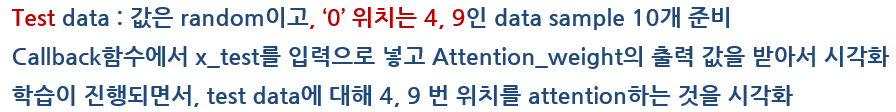

In [40]:
### Training 중에 feature map 시각화 하기
class VisualiseAttentionMap_wo(Callback):
    def __init__(self, model, x_test, x_test_mask):
        super().__init__()
        self.x_test = x_test
        self.x_test_mask = x_test_mask
        # attention weight를 출력하는 모델 구성
        attn_layer = model.get_layer("attention_weight")
        self.attn_model = Model(inputs=model.input, outputs=attn_layer.output)

    def on_epoch_end(self, epoch, logs=None):
        if ((epoch+1) % 5) != 0: return

        # attention weight 추출 # (bs, seq, seq)
        attn = self.attn_model(self.x_test[:,:,0], training=False).numpy()
        attention_map = np.sum(attn, axis=1)  # (bs, seq)

        # 첫 번째 샘플 마스크만 사용
        combined = np.concatenate([attention_map, self.x_test_mask[0:1, :]])

        display.clear_output(wait=True)
        plt.figure(figsize=(3, 2))
        plt.imshow(combined, cmap='hot', aspect='auto')
        plt.axis('off')
        plt.title(f'Iteration {epoch} / {max_epoch}')
        plt.show()

In [41]:
### Training 중에 feature map 시각화 하기
class VisualiseAttentionMap_wi(Callback):
    def __init__(self, model, x_test, x_test_mask):
        super().__init__()
        self.x_test = x_test
        self.x_test_mask = x_test_mask
        # attention weight를 출력하는 모델 구성
        attn_layer = model.get_layer("attention_weight")
        self.attn_model = Model(inputs=model.input, outputs=attn_layer.output)

    def on_epoch_end(self, epoch, logs=None):
        if ((epoch+1) % 5) != 0: return

        # attention weight 추출 # (bs, seq, seq)
        attn = self.attn_model(self.x_test, training=False).numpy()
        attention_map = np.sum(attn, axis=1)  # (bs, seq)

        # 첫 번째 샘플 마스크만 사용
        combined = np.concatenate([attention_map, self.x_test_mask[0:1, :]])

        display.clear_output(wait=True)
        plt.figure(figsize=(3, 2))
        plt.imshow(combined, cmap='hot', aspect='auto')
        plt.axis('off')
        plt.title(f'Iteration {epoch} / {max_epoch}')
        plt.show()

### Self-Attenion (wo/ indexing )

In [42]:
hidden_dim = 16
n_classes = 5
FFN = FeedForward(n_classes, n_classes*4)

shape=(seq_length,1)
inputs = Input(shape=shape)
Q = Dense(hidden_dim, name='Q')(inputs)
K = Dense(hidden_dim, name='K')(inputs)
V = Dense(n_classes, name='V')(inputs)
x = myAttention(Q, K, V)
x = FFN(x)                         #(b,20,5)
x = Flatten()(x)                   #(b,100)
output = Dense(1)(x)               #(b,1)
model = Model(inputs,output)

model.compile(loss='mse', optimizer='adam', metrics=['mape','mae'])

model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 20, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Q (Dense)           │ (None, 20, 16)    │         32 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ K (Dense)           │ (None, 20, 16)    │         32 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ q_k (Lambda)        │ (None, 20, 20)    │          0 │ Q[0][0], K[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sacaled_qk (Lambda) │ (None, 20, 20)    │          0 │ q_k[0][0],        │
│                     │                   │            │ K[0][0]           │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_weight    │ (None, 20, 20)    │          0 │ sacaled_qk[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V (Dense)           │ (None, 20, 5)     │         10 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Lambda)     │ (None, 20, 5)     │          0 │ attention_weight… │
│                     │                   │            │ V[0][0]           │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feed_forward_1      │ (None, 20, 5)     │        225 │ output[0][0]      │
│ (FeedForward)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 100)       │          0 │ feed_forward_1[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 1)         │        101 │ flatten_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 400 (1.56 KB)

 Trainable params: 400 (1.56 KB)

 Non-trainable params: 0 (0.00 B)

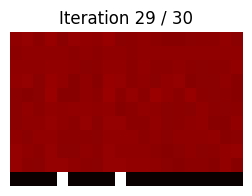

In [43]:
# train.
max_epoch = 30
batch_size = 256
visual_callback = VisualiseAttentionMap_wo(model, x_test, x_test_mask)
history = model.fit(x_train[:,:,0], y_train, validation_data=(x_val[:,:,0], y_val),
                    epochs=max_epoch, batch_size=batch_size,verbose=0,
                    callbacks=[visual_callback])

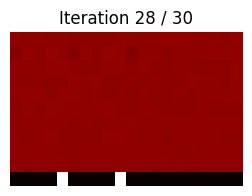

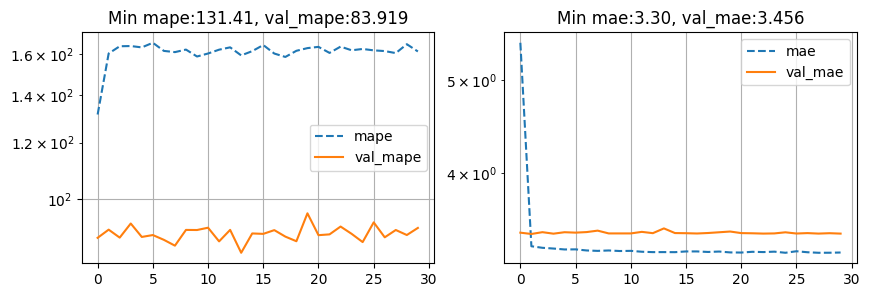

Min Mape:131.41, Min Mae:3.303


In [44]:
plot_loss(history)

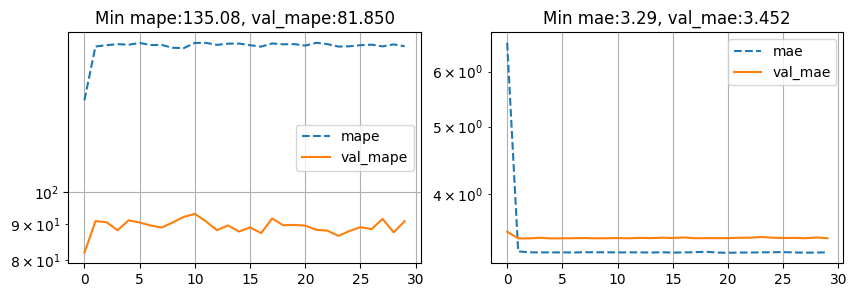

### Self-Attention (w/ index)

In [45]:
hidden_dim = 16 # 32
n_classes = 5 # 1
FFN = FeedForward(n_classes, n_classes*4)
shape=x_train.shape[1:] # (20,5)

inputs = Input(shape=shape)        #(b,20,5)
Q = Dense(hidden_dim, name='Q')(inputs)
K = Dense(hidden_dim, name='K')(inputs)
V = Dense(n_classes, name='V')(inputs)
x = myAttention(Q, K, V)           #(b,20,5)
x = FFN(x)                         #(b,20,5)
x = Flatten()(x)                   #(b,100)
output = Dense(1)(x)               #(b,1)
model = Model(inputs,output)
## adam 보다 RMSprop이 좋음
model.compile(loss='mse', optimizer='RMSprop', metrics=['mape','mae'])
model.summary()
#plot_model(model,'model.png',show_shapes=True)

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 20, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Q (Dense)           │ (None, 20, 16)    │         96 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ K (Dense)           │ (None, 20, 16)    │         96 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ q_k (Lambda)        │ (None, 20, 20)    │          0 │ Q[0][0], K[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sacaled_qk (Lambda) │ (None, 20, 20)    │          0 │ q_k[0][0],        │
│                     │                   │            │ K[0][0]           │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_weight    │ (None, 20, 20)    │          0 │ sacaled_qk[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V (Dense)           │ (None, 20, 5)     │         30 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Lambda)     │ (None, 20, 5)     │          0 │ attention_weight… │
│                     │                   │            │ V[0][0]           │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feed_forward_2      │ (None, 20, 5)     │        225 │ output[0][0]      │
│ (FeedForward)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 100)       │          0 │ feed_forward_2[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 1)         │        101 │ flatten_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 548 (2.14 KB)

 Trainable params: 548 (2.14 KB)

 Non-trainable params: 0 (0.00 B)

Total params: 548


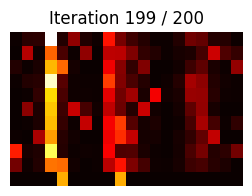

CPU times: user 1min 3s, sys: 5.88 s, total: 1min 9s
Wall time: 57.1 s


In [46]:
%%time
# train.
max_epoch = 200 # 100
batch_size = 256

visual_callback = VisualiseAttentionMap_wi(model, x_test, x_test_mask)
history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                    epochs=max_epoch, verbose=0, batch_size=batch_size,
                    callbacks=[visual_callback])
# Wall time: 1min 17s

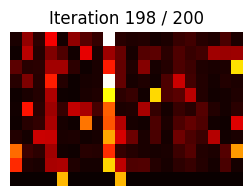

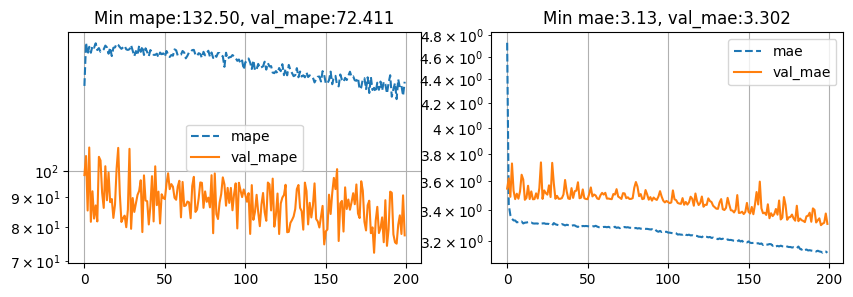

Min Mape:132.50, Min Mae:3.127


In [47]:
plot_loss(history)#,semilog=False)

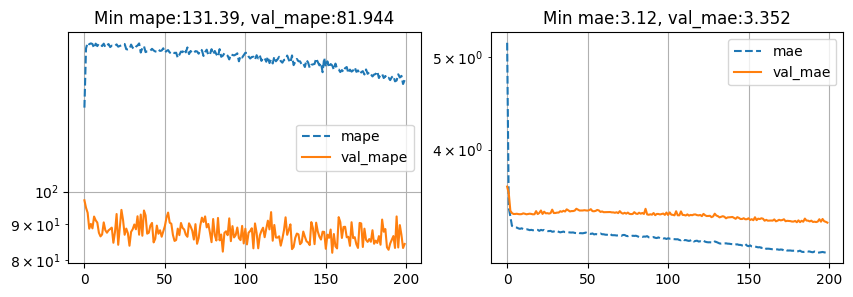

### LSTM + Attention ( wo/ index )

In [48]:
lstm_unit = 9
hidden_dim = 9
n_classes = 5
FFN = FeedForward(n_classes, n_classes*4)
shape=(seq_length,1)

inputs = Input(shape=shape)        #(b,20,1)
x = LSTM(lstm_unit, return_sequences=True)(inputs)#(b,20,9)
Q = Dense(hidden_dim, name='Q')(x) #(b,20,9)
K = Dense(hidden_dim, name='K')(x) # ''
V = Dense(n_classes, name='V')(x)  #(b,20,5)
x = myAttention(Q, K, V)           #(b,20,5)
x = FFN(x)                         #(b,20,5)
x = Flatten()(x)                   #(b,100)
output = Dense(1)(x)               #(b,1)
model = Model(inputs,output)

model.compile(loss='mse', optimizer='adam', metrics=['mape','mae'])
model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 20, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 20, 9)     │        396 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Q (Dense)           │ (None, 20, 9)     │         90 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ K (Dense)           │ (None, 20, 9)     │         90 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ q_k (Lambda)        │ (None, 20, 20)    │          0 │ Q[0][0], K[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sacaled_qk (Lambda) │ (None, 20, 20)    │          0 │ q_k[0][0],        │
│                     │                   │            │ K[0][0]           │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_weight    │ (None, 20, 20)    │          0 │ sacaled_qk[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V (Dense)           │ (None, 20, 5)     │         50 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Lambda)     │ (None, 20, 5)     │          0 │ attention_weight… │
│                     │                   │            │ V[0][0]           │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feed_forward_3      │ (None, 20, 5)     │        225 │ output[0][0]      │
│ (FeedForward)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 100)       │          0 │ feed_forward_3[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 1)         │        101 │ flatten_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 952 (3.72 KB)

 Trainable params: 952 (3.72 KB)

 Non-trainable params: 0 (0.00 B)

Total params: 952

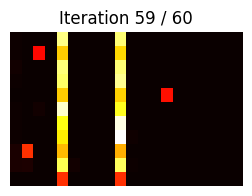

CPU times: user 48.1 s, sys: 3.23 s, total: 51.4 s
Wall time: 41.1 s


In [49]:
%%time
max_epoch = 60
batch_size = 256

visual_callback = VisualiseAttentionMap_wo(model, x_test, x_test_mask)

history = model.fit(x_train[:,:,0], y_train, validation_data=(x_val[:,:,0], y_val),
                    epochs=max_epoch, batch_size=batch_size,verbose=0,
                    callbacks=[visual_callback])
# Wall time: 45.8 s

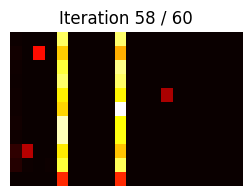

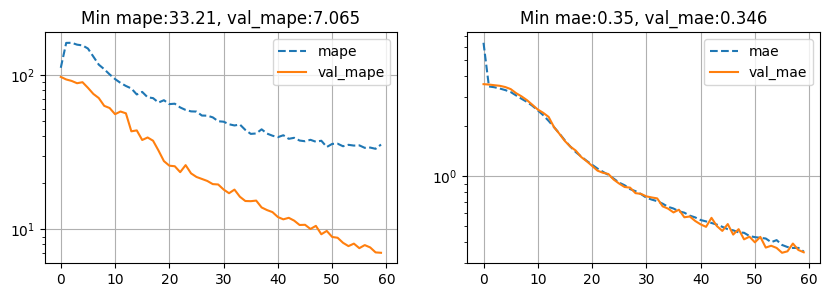

Min Mape:33.21, Min Mae:0.352


In [50]:
plot_loss(history)#,semilog=False)

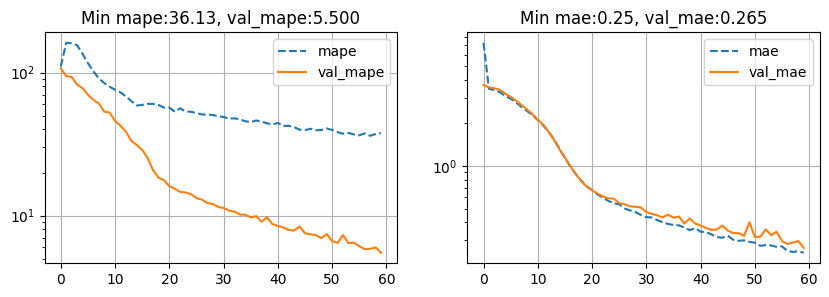

In [51]:
y_pred = model.predict(x_test[:,:,0])
p(y_test)
p(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Shape:(10, 1)
Type: <class 'numpy.ndarray'>
Values: [[15.84450581]
 [ 1.97304869]
 [ 1.67674111]
 [ 5.56544162]
 [15.77302879]
 [12.65185807]
 [ 4.65781466]
 [ 6.28355721]
 [11.68882215]
 [ 0.42328507]]
Shape:(10, 1)
Type: <class 'numpy.ndarray'>
Values: [[15.803314  ]
 [ 3.2385247 ]
 [ 1.6034951 ]
 [ 5.393774  ]
 [13.801571  ]
 [11.9980755 ]
 [ 4.475405  ]
 [ 6.111236  ]
 [10.169111  ]
 [ 0.36051857]]


### LSTM + Attention ( w/ index)

In [52]:
lstm_unit = 9 #
hidden_dim = 9
n_classes = 5
FFN = FeedForward(n_classes, n_classes*4)
shape=x_train.shape[1:] # (20,5)

inputs = Input(shape=shape)
x = LSTM(lstm_unit, return_sequences=True)(inputs)#(b,20,9)
Q = Dense(hidden_dim, name='Q')(x)#(b,20,9)
K = Dense(hidden_dim, name='K')(x)
V = Dense(n_classes, name='V')(x) #(b,20,5)
x = myAttention(Q, K, V)          #(b,20,5)
x = FFN(x)                        #(b,20,5)
x = Flatten()(x)                  #(b,100)
output = Dense(1)(x)              #(b,1)
model = Model(inputs,output)

model.compile(loss='mse', optimizer='adam', metrics=['mape','mae'])
model.summary()

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 20, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 20, 9)     │        540 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Q (Dense)           │ (None, 20, 9)     │         90 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ K (Dense)           │ (None, 20, 9)     │         90 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ q_k (Lambda)        │ (None, 20, 20)    │          0 │ Q[0][0], K[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sacaled_qk (Lambda) │ (None, 20, 20)    │          0 │ q_k[0][0],        │
│                     │                   │            │ K[0][0]           │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_weight    │ (None, 20, 20)    │          0 │ sacaled_qk[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V (Dense)           │ (None, 20, 5)     │         50 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Lambda)     │ (None, 20, 5)     │          0 │ attention_weight… │
│                     │                   │            │ V[0][0]           │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feed_forward_4      │ (None, 20, 5)     │        225 │ output[0][0]      │
│ (FeedForward)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 100)       │          0 │ feed_forward_4[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 1)         │        101 │ flatten_8[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,096 (4.28 KB)

 Trainable params: 1,096 (4.28 KB)

 Non-trainable params: 0 (0.00 B)

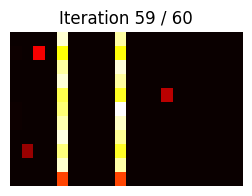

CPU times: user 47.6 s, sys: 3.31 s, total: 50.9 s
Wall time: 41.1 s


In [53]:
%%time
max_epoch = 60
batch_size = 256

visual_callback = VisualiseAttentionMap_wi(model, x_test, x_test_mask)
history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                    epochs=max_epoch, verbose=0, batch_size=batch_size,
                    callbacks=[visual_callback])

Wall time: 1min 8s

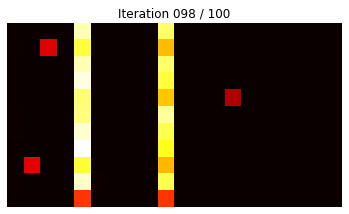

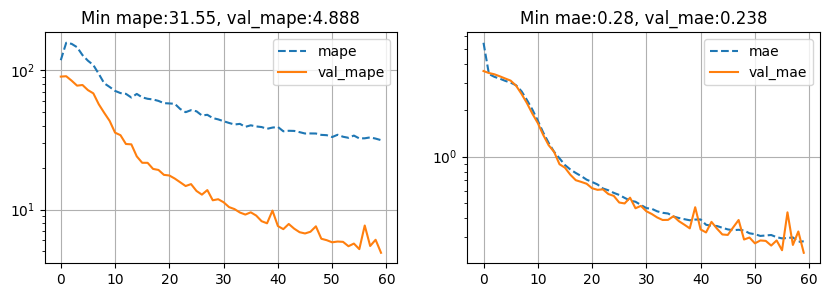

Min Mape:31.55, Min Mae:0.281


In [54]:
plot_loss(history)#,semilog=False)

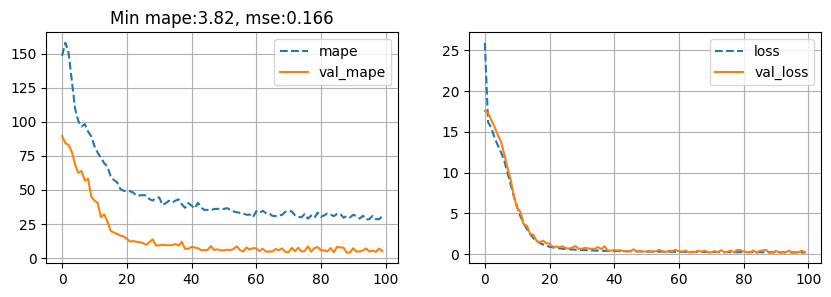

### Stacked Self-Attenion 3layer + No skip connection

In [55]:
class VisualiseAttentionMap_3(Callback):
    def __init__(self, model, x_test, x_test_mask):
        super().__init__()
        self.x_test = x_test
        self.x_test_mask = x_test_mask
        # 각각의 attention 레이어에서 출력 추출할 모델 구성
        self.attn_model_1 = Model(inputs=model.input, outputs=model.get_layer('attention_weight').output)
        self.attn_model_2 = Model(inputs=model.input, outputs=model.get_layer('attention_weight2').output)
        self.attn_model_3 = Model(inputs=model.input, outputs=model.get_layer('attention_weight3').output)

    def on_epoch_end(self, epoch, logs=None):
        if ((epoch+1) % 5) != 0: return

        # 각 attention weight를 예측
        attn1 = self.attn_model_1(self.x_test, training=False).numpy()  # (bs, seq, seq)
        attn2 = self.attn_model_2(self.x_test, training=False).numpy()
        attn3 = self.attn_model_3(self.x_test, training=False).numpy()

        # attention weight → 각 time step으로 합산 (axis=1)
        attn_map1 = np.sum(attn1, axis=1)  # (bs, seq)
        attn_map2 = np.sum(attn2, axis=1)
        attn_map3 = np.sum(attn3, axis=1)

        iteration_no = str(epoch).zfill(3)
        display.clear_output(wait=True)
        plt.figure(figsize=(10, 2))
        for i, attn_map in enumerate([attn_map1, attn_map2, attn_map3]):
            plt.subplot(1, 3, i+1)
            plt.imshow(np.concatenate([attn_map, self.x_test_mask[0:1, :]]), cmap='hot', aspect='auto')
            plt.axis('off')
            if i == 0:
                plt.title(f'Iteration {iteration_no} / {max_epoch}')
        plt.show()


In [56]:
hidden_dim = 16
n_classes = x_train.shape[-1]
FFN1 = FeedForward(n_classes, n_classes*4)
FFN2 = FeedForward(n_classes, n_classes*4)
FFN3 = FeedForward(n_classes, n_classes*4)
shape = x_train.shape[1:] # (20,5)

inputs = Input(shape=shape)       #(b,20,5)
Q = Dense(hidden_dim, name='Q')(inputs)
K = Dense(hidden_dim, name='K')(inputs)
V = Dense(n_classes, name='V')(inputs)
x = myAttention(Q, K, V)          #(b,20,5)
x = FFN1(x)

Q = Dense(hidden_dim, name='Q2')(x)
K = Dense(hidden_dim, name='K2')(x)
V = Dense(n_classes, name='V2')(x)
x = myAttention(Q, K, V,l="2")    #(b,20,5)
x = FFN2(x)

Q = Dense(hidden_dim, name='Q3')(x)
K = Dense(hidden_dim, name='K3')(x)
V = Dense(n_classes, name='V3')(x)
x = myAttention(Q, K, V,l="3")    #(b,20,5)
x = FFN3(x)                       #(b,20,5)
x = Flatten()(x)                  #(b,100)
output = Dense(1)(x)              #(b,1)
model = Model(inputs,output)

model.compile(loss='mse', optimizer='adam', metrics=['mape','mae'])
model.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 20, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Q (Dense)           │ (None, 20, 16)    │         96 │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ K (Dense)           │ (None, 20, 16)    │         96 │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ q_k (Lambda)        │ (None, 20, 20)    │          0 │ Q[0][0], K[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sacaled_qk (Lambda) │ (None, 20, 20)    │          0 │ q_k[0][0],        │
│                     │                   │            │ K[0][0]           │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_weight    │ (None, 20, 20)    │          0 │ sacaled_qk[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V (Dense)           │ (None, 20, 5)     │         30 │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Lambda)     │ (None, 20, 5)     │          0 │ attention_weight… │
│                     │                   │            │ V[0][0]           │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feed_forward_5      │ (None, 20, 5)     │        225 │ output[0][0]      │
│ (FeedForward)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Q2 (Dense)          │ (None, 20, 16)    │         96 │ feed_forward_5[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ K2 (Dense)          │ (None, 20, 16)    │         96 │ feed_forward_5[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ q_k2 (Lambda)       │ (None, 20, 20)    │          0 │ Q2[0][0],         │
│                     │                   │            │ K2[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sacaled_qk2         │ (None, 20, 20)    │          0 │ q_k2[0][0],       │
│ (Lambda)            │                   │            │ K2[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_weight2   │ (None, 20, 20)    │          0 │ sacaled_qk2[0][0] │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V2 (Dense)          │ (None, 20, 5)     │         30 │ feed_forward_5[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output2 (Lambda)    │ (None, 20, 5)     │          0 │ attention_weight… │
│                     │                   │            │ V2[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feed_forward_6      │ (None, 20, 5)     │        225 │ output2[0][0]     │
│ (FeedForward)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Q3 (Dense)          │ (None, 20, 16)    │         96 │ feed_forward_6[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ K3 (Dense)          │ (None, 20, 16)    │         96 │ feed_forward_6[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ q_k3 (Lambda)       │ (None, 20, 20)    │          0 │ Q3[0][0],       

 Total params: 1,442 (5.63 KB)

 Trainable params: 1,442 (5.63 KB)

 Non-trainable params: 0 (0.00 B)

Total params: 1442 (5.63 KB)


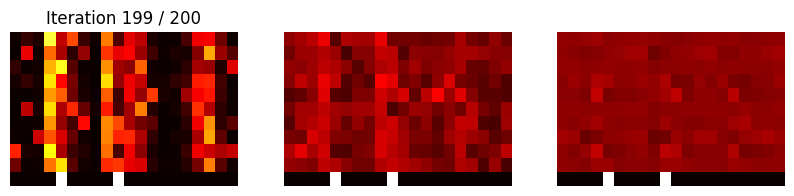

CPU times: user 1min 36s, sys: 6.37 s, total: 1min 42s
Wall time: 1min 22s


In [57]:
%%time
max_epoch = 200
batch_size = 256

visual_callback = VisualiseAttentionMap_3(model, x_test, x_test_mask)
history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                    epochs=max_epoch, verbose=0, batch_size=batch_size,
                    callbacks=[visual_callback])
# Wall time: 1min 26s

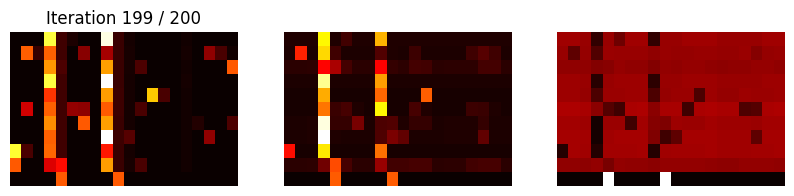

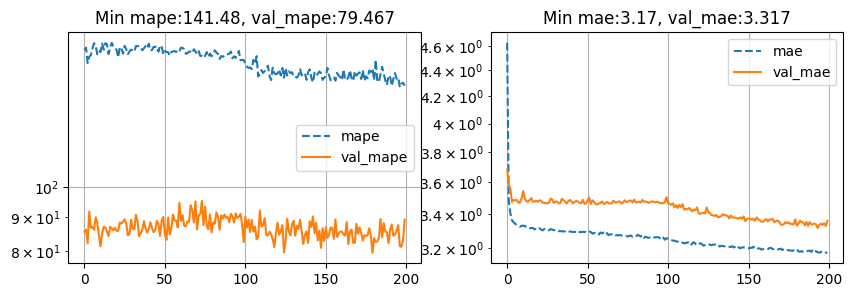

Min Mape:141.48, Min Mae:3.173


In [58]:
plot_loss(history)#,semilog=False)

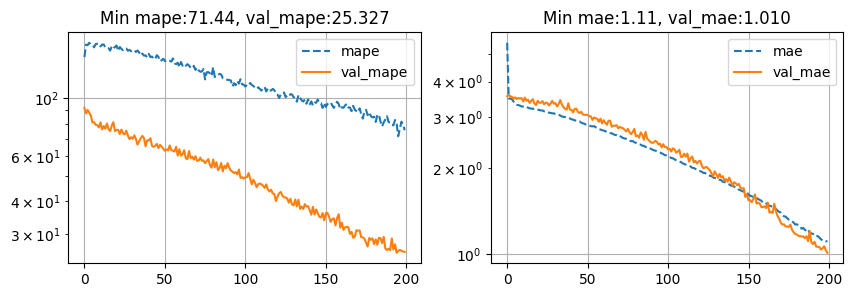

### Stacked Self-Attenion 3layer+ Full skip connection + LayerNormalization

In [59]:
hidden_dim = 32
n_classes = x_train.shape[-1]
FFN1 = FeedForward(n_classes, n_classes*4)
FFN2 = FeedForward(n_classes, n_classes*4)
FFN3 = FeedForward(n_classes, n_classes*4)
shape = x_train.shape[1:] # (20,5)

inputs = Input(shape=shape)         #(b,20,5)
Q = Dense(hidden_dim, name='Q')(inputs)
K = Dense(hidden_dim, name='K')(inputs)
V = Dense(n_classes, name='V')(inputs)
x_A = myAttention(Q, K, V)          #(b,20,5)
x = LayerNormalization()(inputs + x_A )
x = LayerNormalization()(FFN1(x) + x )
Q = Dense(hidden_dim, name='Q2')(x)
K = Dense(hidden_dim, name='K2')(x)
V = Dense(n_classes, name='V2')(x)
x_A = myAttention(Q, K, V,l="2")    #(b,20,5)
x = LayerNormalization()(x_A + x  )
x = LayerNormalization()(FFN2(x) + x )
Q = Dense(hidden_dim, name='Q3')(x)
K = Dense(hidden_dim, name='K3')(x)
V = Dense(n_classes, name='V3')(x)
x_A = myAttention(Q, K, V,l="3")    #(b,20,5)
x = LayerNormalization()(x_A + x  )
x = LayerNormalization()(FFN3(x) + x )
x = Flatten()(x)                    #(b,100)
output = Dense(1)(x)                #(b,1)
model = Model(inputs,output)

model.compile(loss='mse', optimizer='adam', metrics=['mape','mae'])
model.summary()

Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 20, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Q (Dense)           │ (None, 20, 32)    │        192 │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ K (Dense)           │ (None, 20, 32)    │        192 │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ q_k (Lambda)        │ (None, 20, 20)    │          0 │ Q[0][0], K[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sacaled_qk (Lambda) │ (None, 20, 20)    │          0 │ q_k[0][0],        │
│                     │                   │            │ K[0][0]           │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_weight    │ (None, 20, 20)    │          0 │ sacaled_qk[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V (Dense)           │ (None, 20, 5)     │         30 │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Lambda)     │ (None, 20, 5)     │          0 │ attention_weight… │
│                     │                   │            │ V[0][0]           │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 20, 5)     │          0 │ input_layer_19[0… │
│                     │                   │            │ output[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 20, 5)     │         10 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feed_forward_8      │ (None, 20, 5)     │        225 │ layer_normalizat… │
│ (FeedForward)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 20, 5)     │          0 │ feed_forward_8[0… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 5)     │         10 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Q2 (Dense)          │ (None, 20, 32)    │        192 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ K2 (Dense)          │ (None, 20, 32)    │        192 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ q_k2 (Lambda)       │ (None, 20, 20)    │          0 │ Q2[0][0],         │
│                     │                   │            │ K2[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sacaled_qk2         │ (None, 20, 20)    │          0 │ q_k2[0][0],       │
│ (Lambda)            │                   │            │ K2[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_weight2   │ (None, 20, 20)    │          0 │ sacaled_qk2[0][0] │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ V2 (Dense)          │ (None, 20, 5)     │         30 │ layer_normalizat

 Total params: 2,078 (8.12 KB)

 Trainable params: 2,078 (8.12 KB)

 Non-trainable params: 0 (0.00 B)

Total params: 2,078


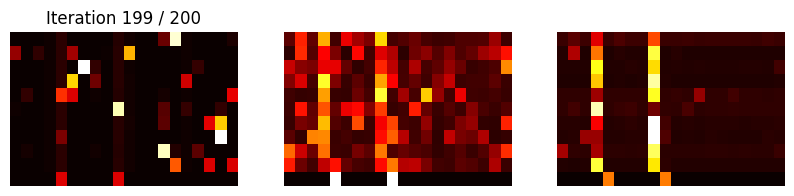

CPU times: user 1min 48s, sys: 7.13 s, total: 1min 55s
Wall time: 1min 36s


In [60]:
%%time
# train.
max_epoch = 200
batch_size = 256

visual_callback = VisualiseAttentionMap_3(model, x_test, x_test_mask)
history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                    epochs=max_epoch, verbose=0, batch_size=batch_size,
                    callbacks=[visual_callback])

Wall time: 4min 51s

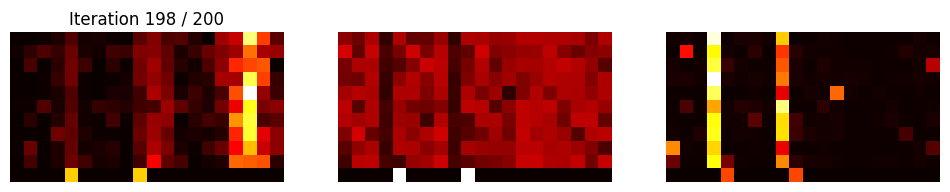

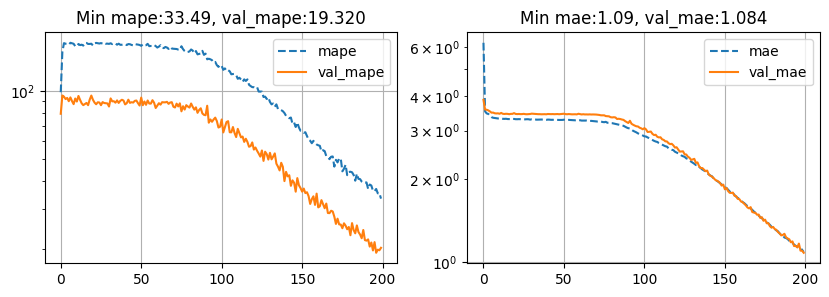

Min Mape:33.49, Min Mae:1.091


In [61]:
plot_loss(history)#,semilog=False)

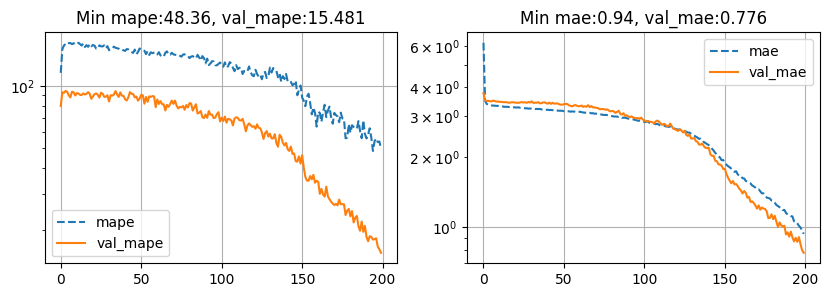

### Multi-Head Attention

#### Embedding Depth: 16

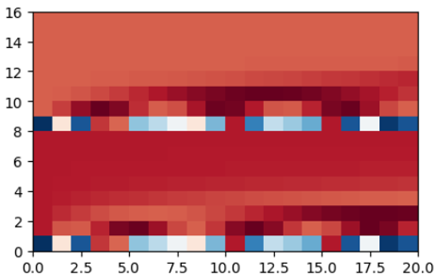

In [62]:
## Append position code
## 학습을 돕기위해 value를 position 사이에 추가
def pos_concat2(x,depth=14) :
    idx = positional_encoding(length=x.shape[1], depth=depth) #(bs,20,14)
    idx = np.tile(idx+1,(x.shape[0],1,1)) # +1:양수값으로
    ret = keras.layers.concatenate([x,idx[:,:,:7],x,idx[:,:,7:]],axis=-1)
    return ret    #(bs,20,16)

In [63]:
np.random.seed(6)

n_train = 20000
n_val = 400
n_test = 10
# data. definition of the problem.
seq_length = 20
#(bs,20,1)
x_train, y_train = task_add_two_numbers_after_delimiter(n_train, seq_length)#(bs,20,1)
x_val, y_val = task_add_two_numbers_after_delimiter(n_val, seq_length)

# 시각화를 위해 '0'위치를 고정
index_1 = 4
index_2 = 9
#(10,20,1)
x_test, y_test = task_add_two_numbers_after_delimiter(n_test, seq_length, 0, index_1, index_2)
# test_index 위치를 시각화 하기 위한 준비
x_test_mask = np.zeros_like(x_test[..., 0])#(10,20)
x_test_mask[:, index_1:index_1 + 1] = 5
x_test_mask[:, index_2:index_2 + 1] = 5
# concat(x_data, position_code)
x_train = pos_concat2(x_train) #(20000,20,16)
x_val = pos_concat2(x_val)     #(400,20,16)
x_test = pos_concat2(x_test)   #(10,20,16)

In [64]:
print(x_val[:2,:,0])
print("")
print(y_val[:2,0])

tf.Tensor(
[[2.534355  3.1068783 9.713581  5.9003654 1.3962394 0.        3.4249299
  2.2833002 2.1486905 0.        6.4391866 5.6013274 7.7686515 2.0698917
  0.8486596 6.9395366 3.4517882 1.8376313 4.0174284 4.8913255]
 [5.5328937 4.834178  7.3424196 2.9239914 1.7097998 1.5136737 4.2154613
  6.4080076 0.        9.504097  0.        0.2313647 5.6390257 4.2529645
  7.295537  0.5774153 2.1126037 8.012429  7.2680187 8.239762 ]], shape=(2, 20), dtype=float32)

[9.86411613 9.7354613 ]


In [65]:
np.set_printoptions(suppress=True)

ps(x_train,"x_train"),ps(y_train,"y_train")
p(x_train[:1,:,:])
p(y_train[:1])

<<x_train>> Shape(20000, 20, 16)
<<y_train>> Shape(20000, 1)
Shape:(1, 20, 16)
Type: <class 'tensorflow.python.framework.ops.EagerTensor'>
Values: [[[8.928601   1.         1.         1.         1.         1.
   1.         1.         8.928601   2.         2.         2.
   2.         2.         2.         2.        ]
  [3.319798   1.841471   1.2650633  1.0719064  1.0193058  1.0051794
   1.0013895  1.0003728  3.319798   1.5403023  1.964231   1.9974114
   1.9998136  1.9999866  1.999999   2.        ]
  [8.212291   1.9092975  1.5111645  1.1434406  1.0386044  1.0103588
   1.002779   1.0007455  8.212291   0.5838531  1.8594829  1.989659
   1.9992546  1.9999464  1.9999962  1.9999998 ]
  [0.41696626 1.14112    1.7206981  1.2142322  1.0578885  1.0155377
   1.0041685  1.0011183  0.41696626 0.0100075  1.6932491  1.9767828
   1.998323   1.9998794  1.9999913  1.9999994 ]
  [1.0765668  0.2431975  1.8786743  1.2839146  1.0771512  1.0207164
   1.0055579  1.0014911  1.0765668  0.3463564  1.4774216  1.9588

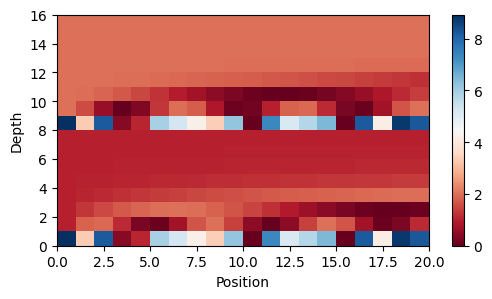

In [66]:
# Plot the dimensions.
plt.figure(figsize=(6,3))
plt.pcolormesh(x_train[0,:,:].numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

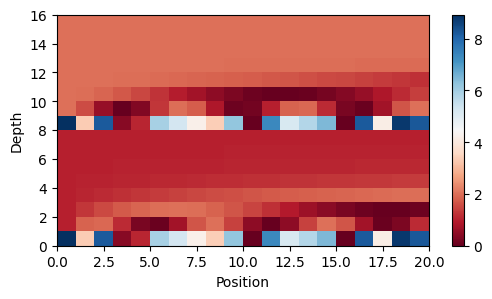

#### Visualise MH-Attention Map





In [67]:
class VisualiseMH_AttentionMap(Callback):
    def __init__(self, model, x_test, x_test_mask):
        super().__init__()
        self.x_test = x_test
        self.x_test_mask = x_test_mask

        # 각 head의 attention weight 레이어를 따로 추출하는 모델 구성
        self.attn_models = [  # output: [y_hat, attn1, attn2, attn3]
            Model(inputs=model.input, outputs=model.outputs[i])
            for i in range(3) ]

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 2 != 0:
            return

        plt.figure(figsize=(6, 5))
        attention_map = []

        for i, attn_model in enumerate(self.attn_models):
            # 각 head에 대해 attention weight 가져오기: (bs, heads=1, seq, seq)
            attn = attn_model(self.x_test, training=False).numpy()  # (bs, seq, seq)
            # 마지막 차원(sum over key axis): (bs, seq_query, 1)
            attn_sum = np.sum(attn, axis=2)  # (bs, seq)
            attention_map.append(attn_sum)

        display.clear_output(wait=True)

        for i in range(3):
            plt.subplot(3, 2, i * 2 + 1)
            if i == 0:
                iteration_no = str(epoch).zfill(3)
                plt.title(f'Iteration {iteration_no} / {max_epoch}')
            plt.imshow(np.concatenate([attention_map[i][:, 0, :], self.x_test_mask[0:1, :]]), cmap='hot', aspect='auto')
            plt.axis('off')

            plt.subplot(3, 2, i * 2 + 2)
            plt.imshow(np.concatenate([attention_map[i][:, 1, :], self.x_test_mask[0:1, :]]), cmap='hot', aspect='auto')
            plt.axis('off')

        plt.show()

#### MultiHeadAttention

In [68]:
def scaled_dot_product_attention(Q, K, V, l=""): ## myAttention 과 동일 weight 추가로 return
    q_k        = Lambda(lambda x: tf.matmul(x[0],x[1],transpose_b=True),name="q_k"+l)((Q, K))
    d_k        = Lambda(lambda x: tf.cast(tf.shape(x)[-1],tf.float32),name="d_k"+l)(K)
    sacaled_qk = Lambda(lambda x: tf.divide(x[0],tf.sqrt(tf.cast(tf.shape(x[1])[-1],tf.float32))),name="sacaled_qk"+l)((q_k, K))
    weight     = Activation('softmax',name="attention_weight"+l)(sacaled_qk)
    output     = Lambda(lambda x: tf.matmul(x[0],x[1]), name='output'+l)((weight,V))
    return output,weight

In [69]:
class MultiHeadAttention(Layer):
    def __init__(self, num_heads, x_dim, l="", name=None):
        super().__init__(name=name)
        self.num_heads = num_heads
        self.depth = x_dim // num_heads
        self.x_dim = x_dim
        self.l = l

        self.wq = Dense(x_dim)
        self.wk = Dense(x_dim)
        self.wv = Dense(x_dim)
        self.out_proj = Dense(x_dim)

    def split_heads(self, x):
        batch_size = tf.shape(x)[0]
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])  # (bs, heads, seq, depth)

    def combine_heads(self, x):
        x = tf.transpose(x, perm=[0, 2, 1, 3])  # (bs, seq, heads, depth)
        batch_size = tf.shape(x)[0]
        seq_len = tf.shape(x)[1]
        return tf.reshape(x, (batch_size, seq_len, self.x_dim))

    def call(self, v, k, q):
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q)
        k = self.split_heads(k)
        v = self.split_heads(v)

        x, attention_weights =  scaled_dot_product_attention(q, k, v)

        x = self.combine_heads(x)
        return self.out_proj(x), attention_weights

In [70]:
num_heads = 2
batch_size = 256

mha = MultiHeadAttention(num_heads,x_train.shape[-1])

y = tf.random.uniform((batch_size, 20, 16))  # (batch_size, encoder_sequence, d_model)
out, aw = mha(y, y, y)
out.shape

# mha1 = MultiHeadAttention(num_heads, x_dim, l='1')
# x_A, attn_w1 = mha1(x, x, x, return_attention=True)

TensorShape([256, 20, 16])

#### Define MHA model

In [71]:
num_heads = 2

shape = x_train.shape[1:] # (20,16)
x_dim = shape[-1]

#hidden_dim = 32
FFN1 = FeedForward(x_dim, x_dim*4)
FFN2 = FeedForward(x_dim, x_dim*4)
FFN3 = FeedForward(x_dim, x_dim*4)
shape = x_train.shape[1:] # (20,16)

inputs = Input(shape=shape)         #(b,20,16)
x= inputs

mha1 = MultiHeadAttention(num_heads, x_dim, l='1')
x_A, attn_w1 = mha1(x, x, x)
x = LayerNormalization()(x + x_A)
x = LayerNormalization(name="LN1")(FFN1(x) + x)

mha2 = MultiHeadAttention(num_heads, x_dim, l='2')
x_A, attn_w2 = mha2(x, x, x)
x = LayerNormalization()(x + x_A)
x = LayerNormalization()(FFN2(x) + x)

mha3 = MultiHeadAttention(num_heads, x_dim, l='3')
x_A, attn_w3 = mha3(x, x, x)
x = LayerNormalization()(x + x_A)
x = LayerNormalization()(FFN3(x) + x)

x = Flatten()(x)                    #(b,320)
output = Dense(1)(x)                #(b,1)
model = Model(inputs=inputs, outputs=[output, attn_w1, attn_w2, attn_w3])

model.compile(loss='mse', optimizer='adam', metrics=['mape','mae'])
model.summary()
#plot_model(model,show_shapes=True)

Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23      │ (None, 20, 16)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ [(None, None,     │      1,088 │ input_layer_23[0… │
│ (MultiHeadAttentio… │ 16), (None, 2,    │            │ input_layer_23[0… │
│                     │ None, None)]      │            │ input_layer_23[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 20, 16)    │          0 │ input_layer_23[0… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 16)    │         32 │ add_6[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feed_forward_11     │ (None, 20, 16)    │      2,128 │ layer_normalizat… │
│ (FeedForward)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 20, 16)    │          0 │ feed_forward_11[… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LN1                 │ (None, 20, 16)    │         32 │ add_7[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ [(None, None,     │      1,088 │ LN1[0][0],        │
│ (MultiHeadAttentio… │ 16), (None, 2,    │            │ LN1[0][0],        │
│                     │ None, None)]      │            │ LN1[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 20, 16)    │          0 │ LN1[0][0],        │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 16)    │         32 │ add_8[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feed_forward_12     │ (None, 20, 16)    │      2,128 │ layer_normalizat… │
│ (FeedForward)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 20, 16)    │          0 │ feed_forward_12[… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 16)    │         32 │ add_9[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ [(None, None,     │      1,088 │ layer_normalizat… │
│ (MultiHeadAttentio… │ 16), (None, 2,    │            │ layer_normalizat… │
│                     │ None, None)]      │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 20, 16)    │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 16)    │         32 │ add_10[0][0]    

 Total params: 10,161 (39.69 KB)

 Trainable params: 10,161 (39.69 KB)

 Non-trainable params: 0 (0.00 B)

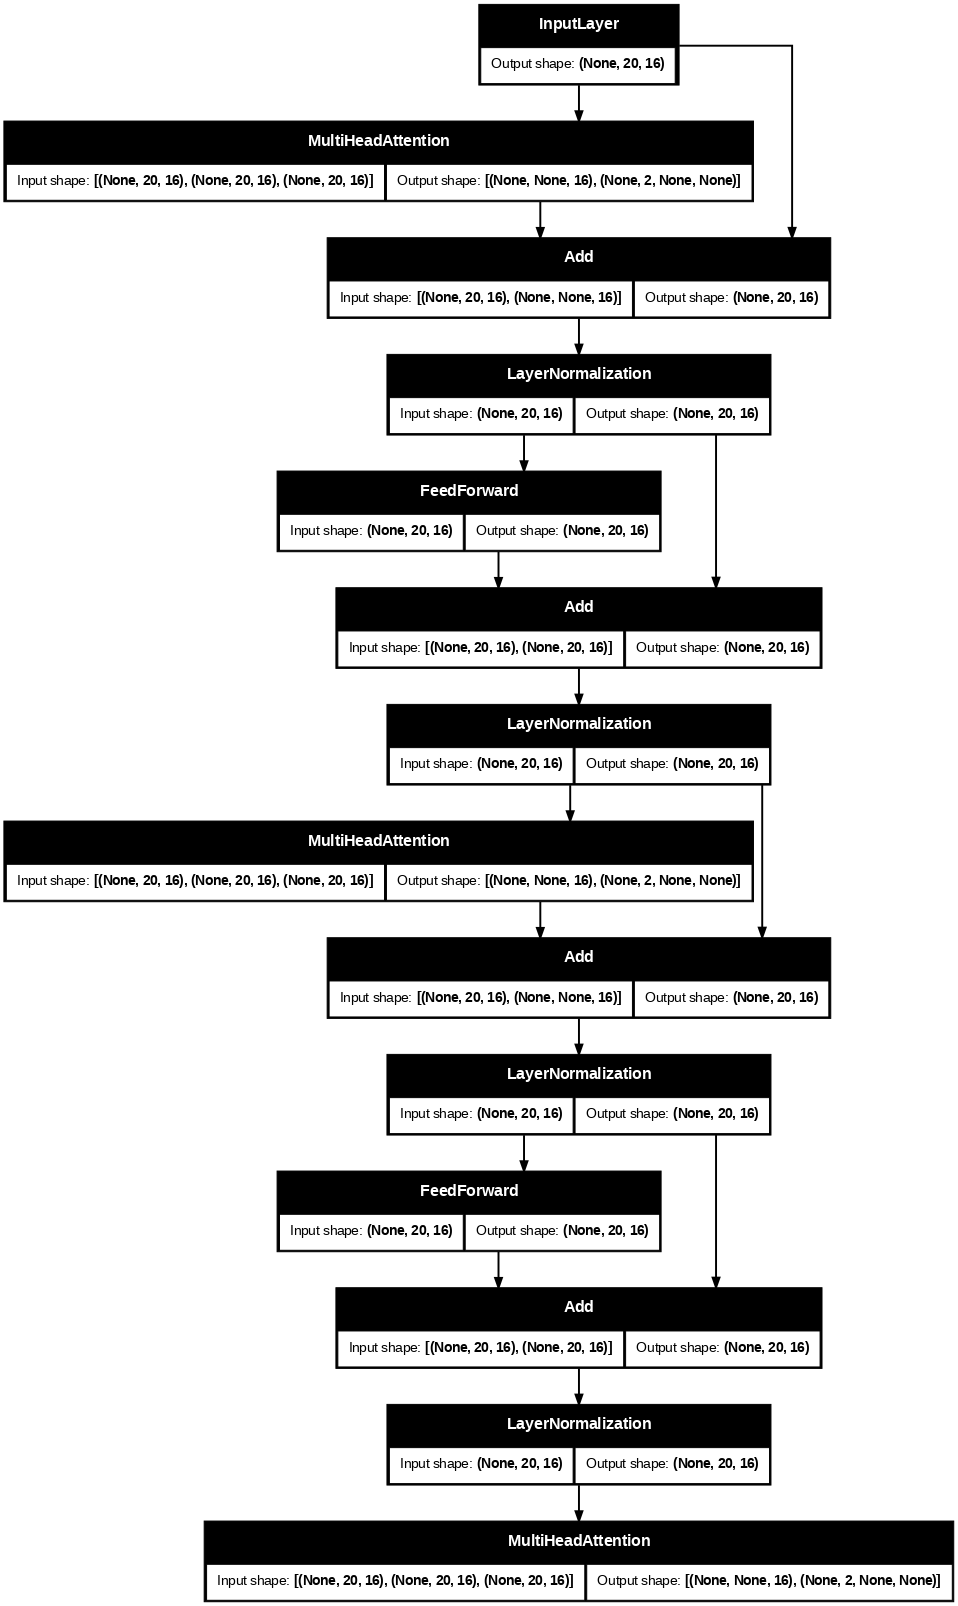

In [72]:
partial_model = Model(inputs=inputs, outputs=attn_w3)
plot_model(partial_model, show_shapes=True, dpi=70)

Total params: 10161 (39.69 KB)


#### Train

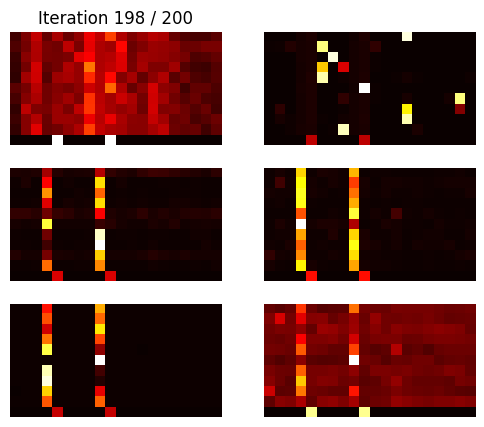

CPU times: user 2min 11s, sys: 6.96 s, total: 2min 18s
Wall time: 2min


In [73]:
%%time
max_epoch = 200
batch_size = 256

# === 학습용 모델 (loss 계산용) ===
train_model = Model(inputs=inputs, outputs=output)
train_model.compile(loss='mse', optimizer='adam', metrics=['mape', 'mae'])

# === 시각화용 모델 (attention weight 추출용) ===
viz_model = Model(inputs=inputs, outputs=[attn_w1, attn_w2, attn_w3])

visual_callback = VisualiseMH_AttentionMap(viz_model, x_test, x_test_mask)
history = train_model.fit(x_train, y_train, validation_data=(x_val, y_val),
                    epochs=max_epoch, verbose=0, batch_size=batch_size,
                    callbacks=[visual_callback])

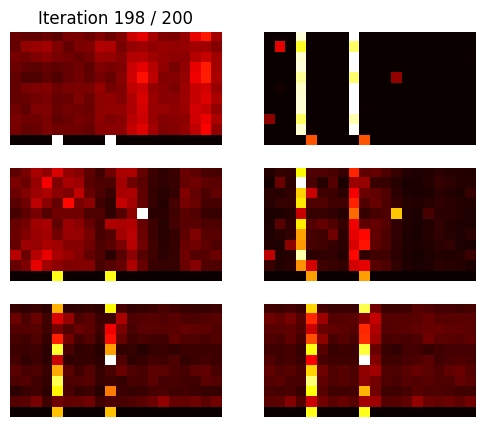

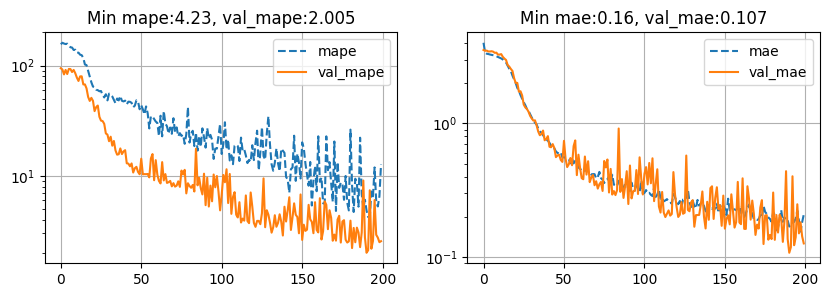

Min Mape:4.23, Min Mae:0.155


In [74]:
plot_loss(history)#,semilog=False)

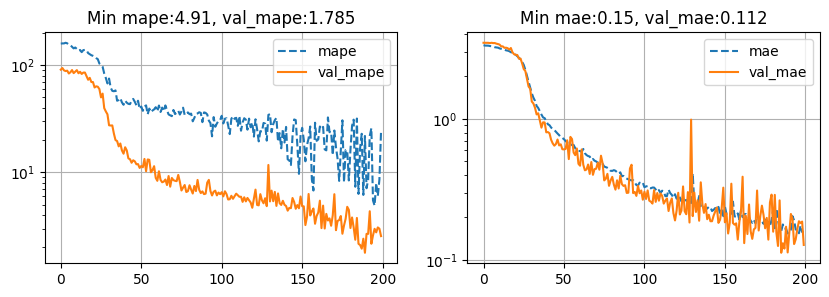

### Bidrectional LSTM ( wo/ index)

In [75]:
shape = x_train[:,:,0:1].shape[1:] #(20,1)
units = 32
inputs = Input(shape=shape)
x = layers.Bidirectional(LSTM(units,return_sequences=True))(inputs)
x = Flatten()(x)
output = Dense(1)(x)
model = Model(inputs,output)

model.compile(loss='mse', optimizer='adam', metrics=['mape','mae'])
model.summary()

Model: "functional_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_27 (InputLayer)     │ (None, 20, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 20, 64)         │         8,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,985 (39.00 KB)

 Trainable params: 9,985 (39.00 KB)

 Non-trainable params: 0 (0.00 B)

units = 9  : Total params: 1,153  


In [76]:
%%time
max_epoch = 200
batch_size = 256

history = model.fit(x_train[:,:,0], y_train, validation_data=(x_val[:,:,0], y_val),
                    epochs=max_epoch, verbose=1, batch_size=batch_size)

Epoch 1/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 45.5336 - mae: 5.4643 - mape: 116.8545 - val_loss: 17.7546 - val_mae: 3.4699 - val_mape: 91.9529
Epoch 2/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 16.5982 - mae: 3.3345 - mape: 150.1698 - val_loss: 17.5637 - val_mae: 3.4559 - val_mape: 89.3240
Epoch 3/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 16.1294 - mae: 3.2771 - mape: 138.8898 - val_loss: 17.4048 - val_mae: 3.4388 - val_mape: 89.0907
Epoch 4/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 15.7585 - mae: 3.2399 - mape: 290.5766 - val_loss: 17.1730 - val_mae: 3.4168 - val_mape: 88.8594
Epoch 5/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 15.2689 - mae: 3.1941 - mape: 135.9955 - val_loss: 16.3023 - val_mae: 3.3191 - val_mape: 84.4158
Epoch 6/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 14.3227 - mae: 3.0800 - mape: 185.1317 - val_loss: 14.3909 - val_mae: 3.0785 - val_mape: 77.2888
Epoch 7/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 12.2

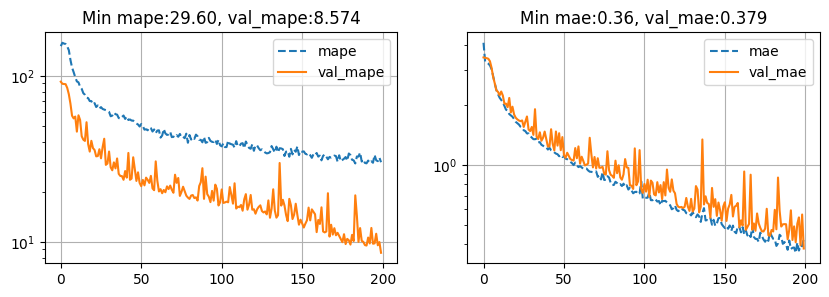

Min Mape:29.60, Min Mae:0.361


In [77]:
plot_loss(history)#,semilog=False)

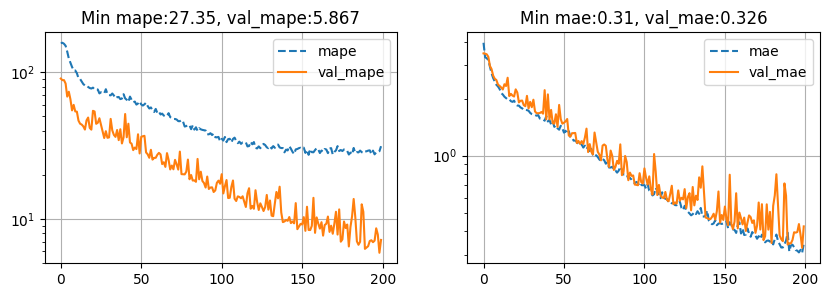

### Bidrectional LSTM ( w/ index)

In [78]:
shape = x_train[:,:,:].shape[1:] #(20,16)
units = 32
inputs = Input(shape=shape)
x = layers.Bidirectional(LSTM(units,return_sequences=True))(inputs)
x = Flatten()(x)
output = Dense(1)(x)
model = Model(inputs,output)

model.compile(loss='mse', optimizer='adam', metrics=['mape','mae'])
model.summary()

Model: "functional_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_28 (InputLayer)     │ (None, 20, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 20, 64)         │        12,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,825 (54.00 KB)

 Trainable params: 13,825 (54.00 KB)

 Non-trainable params: 0 (0.00 B)

units = 9  : Total params: 1,153  


In [79]:
%%time
max_epoch = 200
batch_size = 256

history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                    epochs=max_epoch, verbose=1, batch_size=batch_size)

Epoch 1/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 41.4610 - mae: 5.1509 - mape: 148.0611 - val_loss: 18.1891 - val_mae: 3.5171 - val_mape: 92.6203
Epoch 2/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 16.8194 - mae: 3.3510 - mape: 163.7827 - val_loss: 17.3125 - val_mae: 3.4224 - val_mape: 92.9514
Epoch 3/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 15.9314 - mae: 3.2654 - mape: 108.9865 - val_loss: 16.5376 - val_mae: 3.3516 - val_mape: 80.7942
Epoch 4/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 14.1204 - mae: 3.0633 - mape: 177.2379 - val_loss: 13.3140 - val_mae: 2.9685 - val_mape: 73.5979
Epoch 5/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 10.7299 - mae: 2.6441 - mape: 102.8300 - val_loss: 8.0661 - val_mae: 2.2844 - val_mape: 55.4030
Epoch 6/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.1121 - mae: 2.1132 - mape: 109.0815 - val_loss: 5.7783 - val_mae: 1.9474 - val_mape: 48.5414
Epoch 7/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.1588 

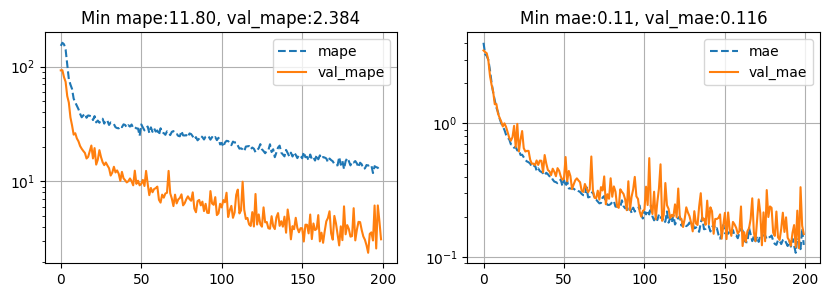

Min Mape:11.80, Min Mae:0.107


In [80]:
plot_loss(history)#,semilog=False)

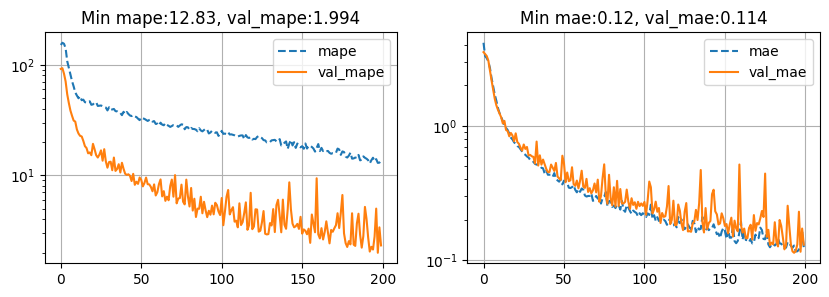